In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.stats
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedGroupKFold

import iridia_af.hyperparameters as hp
import config as cfg
from create_dataset import get_hrv_metrics
from iridia_af.record import Record

In [3]:
metadata_df = pd.read_csv(hp.METADATA_PATH)
metadata_df

,patient_id,patient_sex,patient_age,record_id,record_date,record_start_time,record_end_time,record_timedelta,record_files,record_seconds,record_samples
0,patient_000,female,86,record_000,2012-10-02,2012-10-02T10:50:11,2012-10-03T10:50:02,86391,1,86391,17278200
1,patient_001,female,72,record_001,2011-08-19,2011-08-19T11:19:55,2011-08-21T11:19:54,172799,2,172798,34559600
2,patient_002,male,73,record_002,2012-01-16,2012-01-16T11:29:38,2012-01-17T09:34:22,79484,1,79484,15896800
3,patient_003,female,71,record_003,2017-04-14,2017-04-14T10:18:10,2017-04-15T08:23:04,79494,1,79488,15897790
4,patient_004,female,71,record_004,2008-08-06,2008-08-06T13:01:10,2008-08-07T11:05:49,79479,1,79479,15895800
...,...,...,...,...,...,...,...,...,...,...,...
162,patient_147,male,80,record_162,2016-01-06,2016-01-06T09:32:44,2016-01-07T09:32:43,86399,1,86399,17279800
163,patient_148,female,82,record_163,2009-04-21,2009-04-21T11:55:03,2009-04-25T11:55:02,345599,4,345596,69119200
164,patient_149,female,75,record_164,2010-11-03,2010-11-03T14:11:05,2010-11-04T14:10:56,86391,1,86391,17278200
165,patient_150,male,82,record_165,2010-09-11,2010-09-11T11:20:54,2010-09-13T11:20:53,172799,2,172798,34559600


In [4]:
record_id = "record_104"
metadata_record = metadata_df[metadata_df["record_id"] == record_id]
metadata_record = metadata_record.values[0]
record_path = Path(hp.RECORDS_PATH, record_id)
record = Record(record_path, metadata_record)
record.load_rr_record()

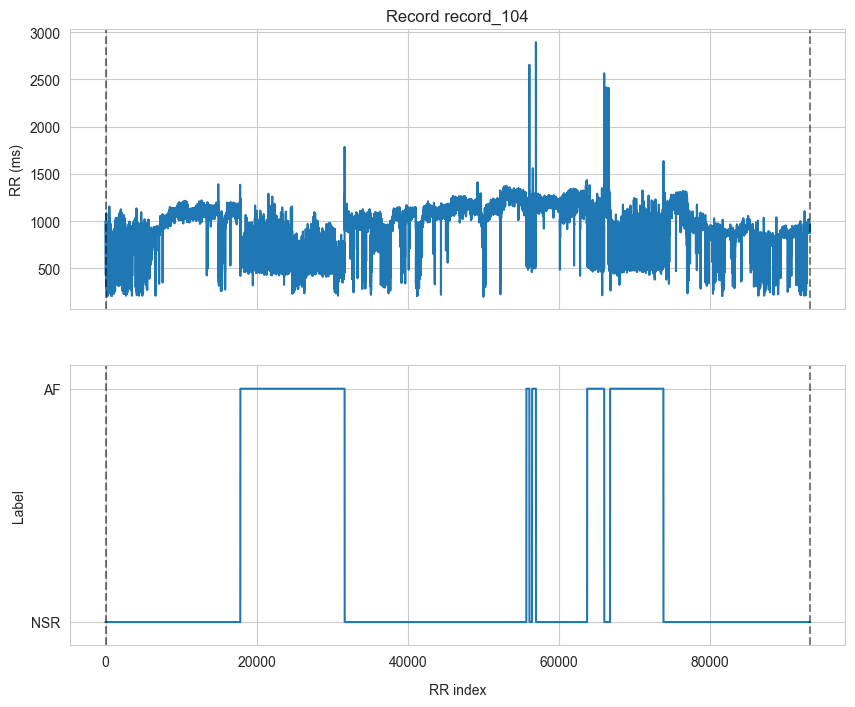

In [5]:
record.plot_rr()

In [6]:
# dataset_path = Path(hp.DATASET_PATH, f"dataset_rr_{hp.WINDOW_SIZE}_2.csv")
dataset_path = Path(hp.DATASET_PATH, f"dataset_rr_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
list_patient = dataset.patient.values
y = dataset.label.values
x = dataset.drop(columns=["label", "patient", "record"]).values

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
    return m, m - h, m + h

In [8]:
metrics = {"roc_auc": [],
           "accuracy": [],
           "sensitivity": [],
           "specificity": [],
           "f1": [],
           "cm": [[0, 0], [0, 0]]
           }

sgkf = StratifiedGroupKFold(n_splits=10, random_state=42, shuffle=True)
for split_id, (train_index, test_index) in enumerate(sgkf.split(x, y, groups=list_patient)):
    print(f"Split {split_id + 1} / {sgkf.n_splits}")
    # model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
    model = xgb.XGBClassifier(objective="binary:logistic",
                              random_state=17, eval_metric="auc",
                              n_estimators=150, max_depth=5,
                              learning_rate=0.2, colsample_bytree=0.8,
                              gamma=0.15, subsample=0.66)
    model.fit(x[train_index], y[train_index])
    y_pred = model.predict(x[test_index])
    y_true = y[test_index]

    cm = confusion_matrix(y_true, y_pred)
    metrics["cm"][0][0] += cm[0][0]
    metrics["cm"][0][1] += cm[0][1]
    metrics["cm"][1][0] += cm[1][0]
    metrics["cm"][1][1] += cm[1][1]

    metrics["roc_auc"].append(roc_auc_score(y_true, y_pred))
    metrics["accuracy"].append((cm[0][0] + cm[1][1]) / sum(sum(cm)))
    metrics["sensitivity"].append(cm[1][1] / (cm[1][1] + cm[1][0]))
    metrics["specificity"].append(cm[0][0] / (cm[0][0] + cm[0][1]))
    metrics["f1"].append(2 * cm[1][1] / (2 * cm[1][1] + cm[0][1] + cm[1][0]))

print(f"Confusion matrix: {metrics['cm']}")
mean, lower, upper = mean_confidence_interval(metrics["roc_auc"])
print(f"ROC AUC score: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["accuracy"])
print(f"Accuracy: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["sensitivity"])
print(f"Sensitivity/Recall: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["specificity"])
print(f"Specificity: {mean:.3f} ({lower:.3f}-{upper:.3f})")
mean, lower, upper = mean_confidence_interval(metrics["f1"])
print(f"F1 score: {mean:.3f} ({lower:.3f}-{upper:.3f})")

Split 1 / 10
Split 2 / 10
Split 3 / 10
Split 4 / 10
Split 5 / 10
Split 6 / 10
Split 7 / 10
Split 8 / 10
Split 9 / 10
Split 10 / 10
Confusion matrix: [[207082, 9515], [4296, 89882]]
ROC AUC score: 0.954 (0.937-0.972)
Accuracy: 0.957 (0.934-0.980)
Sensitivity/Recall: 0.952 (0.925-0.979)
Specificity: 0.957 (0.916-0.998)
F1 score: 0.932 (0.906-0.958)


In [9]:
# train model on all patients except patient 93 from record 104
record_id = "record_104"
patient_id = metadata_df[metadata_df["record_id"] == record_id].patient_id.values[0]

dataset_path = Path(hp.DATASET_PATH, f"dataset_rr_{cfg.WINDOW_SIZE}_{cfg.TRAINING_STEP}.csv")
dataset = pd.read_csv(dataset_path)
dataset = dataset[(dataset.record != record_id) & (dataset.patient != patient_id)]
list_patient = dataset.patient.values

y = dataset.label.values
x = dataset.drop(columns=["label", "patient", "record"]).values

In [10]:
model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
model.fit(x, y)
y_pred = model.predict(x)
cm = confusion_matrix(y, y_pred)
cm

array([[209041,   6883],
       [  1842,  92079]])

In [11]:
record_path = Path(hp.RECORDS_PATH, record_id)
record = Record(record_path, metadata_record)
record.load_rr_record()

day_pred = []
for day_index in range(record.num_days):
    all_y_pred = [[] for _ in range(len(record.rr[day_index]))]
    for i in range(0, len(record.rr[day_index]) - cfg.WINDOW_SIZE, cfg.PREDICTION_STEP):
        rr_window = record.rr[day_index][i:i + cfg.WINDOW_SIZE]
        hrv_window = get_hrv_metrics(rr_window)
        x = np.array(list(hrv_window.values()))
        x = x.reshape(1, -1)
        y_pred = model.predict(x)
        for j in range(i, i + cfg.WINDOW_SIZE):
            all_y_pred[j].append(y_pred)

    new_all_y_pred = []
    for list_pred in all_y_pred:
        if len(list_pred) == 0:
            new_all_y_pred.append(0)
        else:
            new_all_y_pred.append(np.mean(list_pred))
    all_y_pred = np.array(new_all_y_pred)
    all_y_pred_threshold = np.where(all_y_pred > 0.5, 1, 0)
    day_pred.append(all_y_pred)

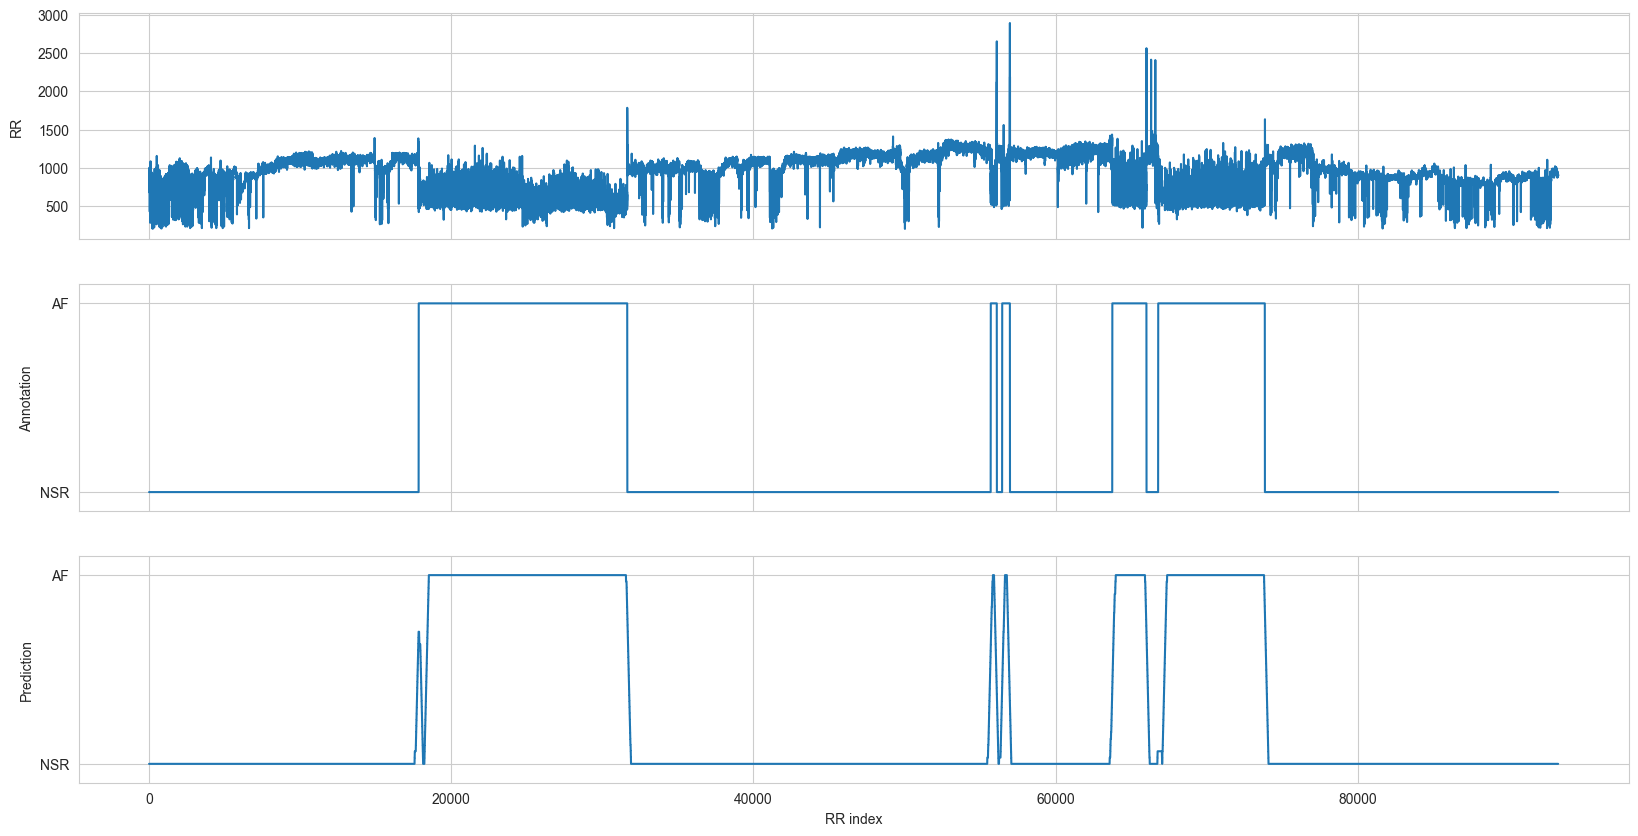

In [12]:
for day_index in range(record.num_days):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(20, 10))

    ax[0].plot(record.rr[day_index])
    ax[0].set_ylabel("RR", labelpad=10)

    ax[1].plot(record.rr_labels[day_index])
    ax[1].set_ylabel("Annotation")
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_yticks([0, 1])
    ax[1].set_yticklabels(["NSR", "AF"])

    ax[2].plot(day_pred[day_index])
    ax[2].set_ylabel("Prediction")
    ax[2].set_ylim(-0.1, 1.1)
    ax[2].set_yticks([0, 1])
    ax[2].set_yticklabels(["NSR", "AF"])

    ax[-1].set_xlabel("RR index")

    plt.show()
    plt.close("all")